# Computer Vision for Set-Up Calibration
---

In this script we present the three ideas explained in C.1.2 for the calibration of the set-up, in addition to a simple real time visualizer. For new cameras, the code should be adapted to the new API.

### $(1.)$ - [*RAW VISUALIZATION*](#1)
### $(2.)$ - [*UNIFORMITY OF CP RING*](#2)
### $(3.)$ - [*PROXIMITY TO SQUARED COSINE*](#3)
### $(4.)$ - [*PROXIMITY TO SIMULATED IMAGE*](#4)
---

<a id='1'></a>
## $(1.)$ Raw Visualization

This Section allows the real time visualization and saving of the visualized images.
It has an option to show 3D plots of the visualized image (this can slow down the whole process for many computers).

**Fix Parameters**

In [ ]:
# Camera parameters ------------------------------------------------
exposure_time = 98 #us 
max_images_grabbed = 10000000 # Max number of images to be grabbed. Big for non-stop
one_every = 2 # save an image every X shown ones
photos_to_save = 20 # total images saved. !When achieved code will stop!

# Showed Image Parameters -------------------------------------------
show_3D_plot = True
# if true, choose an natural number. 1 will give the plotter all the pixels 
# 2, only one every 2 pixels etc. The higher, the faster the rendering of the 3D plot
downscale_3D_plot = 1

# Saved Image Parameters --------------------------------------------
exp_name = "Experimento_Ortogonal_HeNe" # Name of directory with saved images
img_prefix = "0_2" # Prefix of the photos that will be saved
# Path where output should be saved:
output_path = f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/LAB/EXPERIMENTAL/"
save_3D_too = False # If true they will also be saved in the same directory

Note: if in your screen you cannot visualize the 2d and 3d plots side by side, then try changing the following pairs, maintaining each pairs relative ratios.

In [ ]:
plot2d_width = 7  #inches
plot2d_height = 6 #inches

plot3d_width = 500  #pixels
plot3d_height = 450   #pixels

**Code**

In [ ]:
# Import camera's controller
from pypylon import pylon
from pypylon import genicam
# Numpy, Matplotlib, Plotly, Os and OpenCV (for image manipulation)
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # nice and fast surface plots
import os
import cv2
# To erase previous output in same cell
from IPython.display import clear_output


# Make the notebook's layout more practical for our purposes
from IPython.display import display, HTML

# Output stuff in rows, so we can see the 2D and 3D plots side by side
display(HTML('<style>{}</style>'.format("""
.output {
    flex-direction: row;
    flex-wrap: wrap;
}

.output_area {
    flex-basis: 48%; /* Make each element take up 48% of the row */
}
""")))

# Take margins of notebook out to see images bigger
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [ ]:
# Plotting routines
def plotter_2d(im, title, width=plot2d_width, height= plot2d_height): 
    # plot a colormap of im and the contracted profiles
    prof_x=np.sum(im, axis=0)
    prof_y=np.sum(im, axis=1)
    fig,ax = plt.subplots(2,2,figsize = (width,height),gridspec_kw={'height_ratios': [4, 1],'width_ratios': [4, 1]})
    ax[0,0].imshow(im)
    ax[0,0].set_title(title)
    ax[0,1].scatter(prof_y, np.arange(len(prof_y)), s=1, label=f'Intensity profile in y')
    ax[0,1].set_ylim((0,len(prof_y)))
    ax[0,1].invert_yaxis()
    ax[1,0].scatter(np.arange(len(prof_x)), prof_x, s=1, label=f'Intensity profile in x')
    ax[1,0].set_xlim((0,len(prof_x)))
    ax[1,0].invert_yaxis()
    ax[1,1].axis('off')
    ax[1,1].text(0,0.5,"Total intensty:")
    ax[1,1].text(0,0.3,f"{np.sum(im)}")
    fig.tight_layout()
    plt.show()
    
def plotter_3d(im, title, aspect, resol_downscale_factor=1,
                   width = plot3d_width, height=plot3d_height): 
    # plot a 3D surface of the input image
    # only one every resol_downscale_factor pixel in height and width will be plotted
    # it should be an integer! Higher -> faster plot.
    # To make the plot faster you can also make width or height smaller!
    # aspect is aspect ratio list e.g., [1,2]
    fig = go.Figure(data=[go.Surface(z=im[::resol_downscale_factor,::resol_downscale_factor], 
                                     colorscale='Portland')])
    fig.update_layout(title=title, autosize=False,
        width=width, height=height,
        margin=dict(l=1, r=1, b=1, t=30),
        scene={"aspectratio": {"x": aspect[0], "y": aspect[1], "z": 1}})
    fig.show()
    return fig


# output directory creation
output_path += exp_name
os.makedirs(output_path, exist_ok=True)

# Create an instant camera object with the camera device found first
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

# Print the model name of the camera.
print("Using device ", camera.GetDeviceInfo().GetModelName())

# Get width and height of captured images (pixel number)
w = camera.Width.GetValue()
h = camera.Height.GetValue()
print(f"Captured images have width={w} height={h}")
aspect=[max(w,h)/w,max(w,h)/h] # aspect ratio e.g., 1:2

# Set some parameters for camera to custom values
camera.ExposureTime.SetValue(exposure_time) 
camera.MaxNumBuffer = 1 # count of buffers allocated for grabbing. Default is 10

# Start the grabbing of max_images_grabbed images.
camera.StartGrabbingMax(max_images_grabbed) # by default is free-running continous acquisit

i=0 # count of shown images
j=0 # count of the saved images
while camera.IsGrabbing():
    # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)

    if grabResult.GrabSucceeded(): #if grabbed succesfully
        # Access the image data as numpy array
        img = grabResult.Array
        clear_output(wait=True) # erase notebook cell's previous output
        plotter_2d(img, f"Image {i}")
        i+=1
        if show_3D_plot:
            fig3d = plotter_3d(img, f"Image {i}", aspect)
            
        if i%one_every==0: # every 'one_every' showed images save one
            cv2.imwrite(f"{output_path}/{img_prefix}_{j}.png", img)
            if save_3D_too:
                fig3d.write_image(f"{output_path}/{img_prefix}_{j}_3D.png")
            j+=1
            if j>=photos_to_save:
                break
    else:
        print("Error grabbing: ", grabResult.ErrorCode, grabResult.ErrorDescription)
    grabResult.Release()
camera.Close()

<a id='2'></a>
## $(2.)$ Uniformity of CP Ring

This analyzer **assumes a circular polarization input**
light. 

It takes the camera images in real time through Blazquez’s Algorithm (B.6.7) to obtain
their geometrical centers. 

We know that the angular profile around this
center should be a constant if the experimental set-up is perfect, with the light beam going exactly along the optical axis etc. 

Hence, **we fit a line
to the angular profile (which ideally should have slope 0) and print in real time the slope of the fitted line.**
The optimal crystal-beam
configuration will be achieved when the slope is closest to zero and visually the ring satisfies the proper
intuition. We also output the distance between the gravicenter of the image and the geometric center of it. If there was no noise this should yield 0.

There will always be experimental noise, meaning we will never obtain a flat angular profile.
Hence, the RANSAC method is used to fit the line (instead of a least squares approach) since it
allows us to get rid of the outliers that unbalance the line.

**Fix Parameters**

In [ ]:
# Camera parameters ------------------------------------------------
exposure_time = 98 #us 
max_images_grabbed = 10000000 # Max number of images to be grabbed. Big for non-stop
average_images = 10 # Grab X images, average them and run algorithm on result

# algorithm parameters ----------------------------------------------
length_of_the_log = 100 # show a plot of the last X-many image's fitting errors and slopes

Necessary Imports and Functions

In [ ]:
from pypylon import pylon
from pypylon import genicam
import cv2
from IPython.display import clear_output
import os
import numpy as np
import matplotlib.pyplot as plt


import scipy
import skopt
import sklearn.linear_model
from skimage.transform import warp_polar


def rotate_image_by( image_array, angle, center,interpolation_flag):
    """Rotate input image_array (2D image array) an angle (in rad) with respect to center
    (expected to be a pair [h,w]), with interpolation alg given in inteprolation_flag
    Interp. opts in https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121
    """
    a=np.cos(angle)
    b=np.sin(angle)
    rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                         [-b, a, center[1]*b+center[0]*(1-a)]])
    return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)

        
def get_Blazquez_metric(center_h_w, im,  interpolation_flag):
    """Given a center_h_w (a pair of numbers giving pixel coordinates), first sum the input image im 
    (2D image array) with its pi rotated version to get im_pi_im. Take this result and pi/2 rotate it 
    to compute the pointwise differece with im_pi_im. Return mean absolute difference.
    """
    im_pi_im = rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
    return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))


def get_histo_and_fit_line(center_h_w, im, theta_N, rad_N, 
                      max_rad, rad_scaling, interpol_order, 
                      ransac_opts={'min_samples':0.5, 'max_trials':80, 'residual_threshold':0.05}): 
    '''Get the least square error fit of the input image's angular histogram about 
    center_h_w to the function: y   = A+Bx  using RANSAC
        
    Arguments
    --------
    - center_h_w: 1D array of 2 entries representing pixel coordinates of the center around which 
                    the angular histogram will be computed
    - im: 2D array image to be converted to polar coordinates and then integrated radially to get
            the 2D histogram
    - theta_N: number of angular bins to split the image in (pizza portions)
    - rad_N: number of bins to split radially each pizza portion (i.e., [theta_N,rad_N] is
                the discretization of the polar coordinate version of the input image)
    - max_rad: Maximum radial distance to consider when computing the polar coord. image
    - rad_scaling: whether to get polar or log-polar
    - interpol_order: order of interpolation in the output-input polar coordinate image calculation
    - ransac_opts: options for the ransac algorithm. For their meaning see:
                https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html
    '''
    # convert image to polar coordinates around center_h_w. The result is again a 2D array of [theta_N,rad_N]
    im_polar = warp_polar(im, center=center_h_w, 
                    output_shape=(theta_N, rad_N), 
                    radius=max_rad,
                    scaling=rad_scaling,
                    order=interpol_order)
    # sum over radial directions to get angular histogram
    hist = im_polar.sum(axis=1)
    # range of angles of the hisotgram (the abscisa for the plot)
    supp_phis = np.linspace(0, np.pi*2, theta_N)
    # prepare matrix for linear fit
    A = np.vstack((np.ones(len(hist)), supp_phis)).T
    # run RANSAC "line" (secretly cosine square) fit
    model = sk.linear_model.RANSACRegressor(base_estimator=sklearn.linear_model.LinearRegression(),
                min_samples=ransac_opts['min_samples'], max_trials=ransac_opts['max_trials'], 
                residual_threshold=ransac_opts['residual_threshold'],
                #stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss='absolute_error',
                random_state=666)
    model = model.fit(A[:,1:], hist)
    # total error of resulting fit
    ls_res = np.sum( model.score(A[:,1:], hist)  ) 
    return ls_res, model, hist, supp_phis # least sq error, fitted coeffs, histogram, abscisa angles


    
def compute_intensity_gravity_center(image):
    """ Compute the gravity center of the image (a 2D array)"""
    # total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def normalize_to_max(image): 
    """Take image to float and divide by its maximum value so that
    the intensities range from 0 to 1, being 1 maximum intensity"""
    return image.astype(np.float64)/np.max(image)


def get_geomcenter_angular_prof(image, preprocess_fct, get_grav_fct, blazq_alg_kw_args):
    '''Body of Blazquez Alg.+ Apply Line Fit to Result
    Inputs
    ------
    - image: 2D numpy array of image to process
    - preprocess_fct: input inmage will be preprocessed with it
    - get_grav_fct: Routine to obtain gravicenter from an image
    - blazq_alg_kw_args : keyword arguments specifying the options for the algorithm. Example:
        blazq_alg_kw_args = { 'method':'Nelder-Mead' or 'Powell', # choose optimizer for 2D geom center search
            'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0, # params for 2D geom center search 
                see https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html
                    https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html
            'rad_scaling':'linear', 'interpolation_order':3, # for polar image generation. see get_histo_and_fit_cos_squared
            'theta_N':360*10**1, 'rad_N':50, # for polar image generation. See get_histo_and_fit_cos_squared
            'ransac_opts':{'min_samples':0.5, 'max_trials':80, 'residual_threshold':0.05}, # for cosine sq fit see get_histo_and_fit_cos_squared
            'get_grav_angle':True # compute angle not only with ransac fit but also using grav and geom center known-> main symmetry axis too
            }
    '''
    # Pre-process the image if necessary using input function
    image = preprocess_fct( image ) 
    # Get the gravicenter of input image using given function for that
    grav_center = get_grav_fct(image) #[N_pbs, 2]

    # prepare function to input to optimizer
    # metric to optimize in the search of geometric center
    metric_to_opt = lambda c_h_w : get_Blazquez_metric(c_h_w, im=image, interpolation_flag=cv2.INTER_CUBIC)
    
    # optimizer options
    options={'maxiter':blazq_alg_kw_args['max_it'],
                'maxfev': blazq_alg_kw_args['max_evals']}
    # optimizer choice
    if blazq_alg_kw_args['method']=='Nelder-Mead':
        options['xatol']=blazq_alg_kw_args['abs_tol']
        options['fatol']=blazq_alg_kw_args['rel_tol']
    elif blazq_alg_kw_args['method']=='Powell':
        options['xtol']=blazq_alg_kw_args['abs_tol']
        options['ftol']=blazq_alg_kw_args['rel_tol']

    t0=time()
    # BLAZQ. ALGORITHM ###############################################################
    # run optimization with gravicenter as initial guess
    res = scipy.optimize.minimize(metric_to_opt, grav_center, method=blazq_alg_kw_args['method'],
                                    bounds=((0,image.shape[0]),(0, image.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
    # result should be geometric center
    geom_center = res.x
    ##################################################################################
    
    # FIT LINE TO RESULTING ANGULAR HISTOGRAM ##############################
    # lambda with preferences for polar histograms and curve fits on it
    get_fit = lambda c_h_w, im : get_histo_and_fit_cos_squared(c_h_w, im, 
                                            ransac_opts=blazq_alg_kw_args['ransac_opts'],
                                            theta_N=blazq_alg_kw_args['theta_N'],
                                            rad_N=blazq_alg_kw_args['rad_N'],
                                            max_rad=blazq_alg_kw_args['max_rad'],
                                            rad_scaling=blazq_alg_kw_args['rad_scaling'], 
                                            interpol_order=blazq_alg_kw_args['interpolation_order'])
    # Fit cosine squared to the angular profile
    fitted_er, betas, angular_profile, supp_phis = get_fit(geom_center, image)
    # Extract from resulting optimal line fit slope coefficient
    slope_ransac = betas.estimator_.coef_[1]
    # get fitted angular profile
    fitted = betas.estimator_.predict(np.vstack(( supp_phis)).T)
    ##################################################################################    
    
    t0 = time()-t0
    
    return geom_center, grav_center, angular_profile, fitted, betas, slope_ransac

**Main**

In [ ]:
blazq_alg_kw_args = { 'method':'Nelder-Mead', # optimizer for 2D geom center search
    'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0, # params for 2D geom center search
    'rad_scaling':'linear', 'interpolation_order':3, # for polar image generation
    'theta_N':360*10**1, 'rad_N':50, # for polar image generation
    'ransac_opts':{'min_samples':0.5, 'max_trials':80, 'residual_threshold':0.05}, # for cosine sq fit
    'get_grav_angle':True # compute angle not only with ransac fit but also using grav and geom center known-> main symmetry axis too
        }

# Create an instant camera object with the camera device found first
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

# Print the model name of the camera.
print("Using device ", camera.GetDeviceInfo().GetModelName())

# Get width and height of captured images (pixel number)
w = camera.Width.GetValue()
h = camera.Height.GetValue()
print(f"Captured images have width={w} height={h}")
s = min(w,h)
w = s
h = s
print(f"Cropping to {w}x{h}")
blazq_alg_kw_args['max_rad'] = 2*w//3 # max radial distance for polar image generation
# container for the image
img = np.zeros((h,w), dtype=np.float64)

# Set some parameters for camera to custom values
camera.ExposureTime.SetValue(exposure_time) 
camera.MaxNumBuffer = 1 # count of buffers allocated for grabbing. Default is 10

# Start the grabbing of max_images_grabbed images.
camera.StartGrabbingMax(max_images_grabbed) # by default is free-running continous acquisit

# RANSAC Errors
error_history = np.zeros((length_of_the_log), dtype=np.float64)
# slope history
slope_history = np.zeros((length_of_the_log), dtype=np.float64)


i=0 # count of shown images
while camera.IsGrabbing():
    # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    # Move errors in array
    error_history[1:] = error_history[:-1]
    slope_history[1:] = slope_history[:-1]

    if grabResult.GrabSucceeded(): #if grabbed succesfully
        # Access the image data as numpy array
        i+=1
        img += grabResult.Array[:w,:h] # note we only take a square portion of the camera sensor
        if i % average_images==average_images-1: # every one_every images run alg
            img/=average_images # average captured images
            # compute geometric center, angular histogram and fit to cosine square (so also estimate of phiCR)
            geom, grav, angular_profile, fitted, betas, slope_history[0], error_history[0], t0, supp_phis = \
                            get_geomcenter_angular_prof( img, normalize_to_max, compute_intensity_gravity_center,
                                                        blazq_alg_kw_args )
            # distance from geometric to gravitational center of image. Idealy should be zero if no noise
            dist_geo_grav = np.sqrt((geom[0]-grav[0])**2+(geom[1]-grav[1])**2)
            clear_output(wait=True) # erase notebook cell's previous output
            # Plot results
            fig, axs = plt.subplots(2, 2, figsize=(20,10))
            axs[0,0].imshow(img)
            axs[0,0].set_title(f"Experimt. Img {i}, w={w} h={h}\ndistce grav-geom={dist_geo_grav:.3}pix")
            axs[0,0].plot(geom[1],geom[0], 'or', label="Geometric Center")
            axs[0,0].plot(grav[1],grav[0], 'oy', label="Gravicenter")
            # plot main axis
            #axs[0,0].plot([0,img.shape[0]-1],[-grav[1]*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0], (img.shape[0]-1-grav[1])*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0]], '-w')
            #axs[0,0].set_xlim((0, img.shape[1]))
            #axs[0,0].set_ylim((0, img.shape[0]))
            axs[0,0].legend()
            # plot resulting hitogram and fit
            axs[0,1].plot(supp_phis[betas.inlier_mask_], np.zeros(np.sum(betas.inlier_mask_)), 'o', markersize=1, label="Inliers")
            axs[0,1].plot(supp_phis, angular_profile, label="Histogram at optimal geometric center")
            axs[0,1].plot(supp_phis, fitted, label="Fitted Line")
            axs[0,1].legend()
            axs[0,1].set_title(f"Angular Histogram From Geometric Center\n Slope={slope_history[0]:.3}")
            axs[1,0].plot(error_history, 'o-', markersize=2)
            axs[1,0].set_ylim(bottom=0)
            axs[1,0].set_xlabel("How many images ago?")
            axs[1,0].set_ylabel("Line Fitting Error")
            axs[1,1].plot(slope_history, 'o-', markersize=2)
            axs[1,1].hlines(y=0, colors='red')
            axs[1,1].set_xlabel("How many images ago?")
            axs[1,1].set_ylabel("Fitted Slope")

            print(f"Processing time: {t0}s; **RANSAC ERROR: {error_history[0]:.3}**, n trials: {betas.n_trials_}, inliers: {np.sum(betas.inlier_mask_)}")
            print(f"**FITTED SLOPE: {slope_history[0]:.3}**, **Distance from gravicenter to geometric: {dist_geo_grav} pixels**")
            print(f"Total Sum of whole Image Pixels {img.sum()}. Sum per quadrant around the geometric center:")
            geom=geom.astype(int)
            print(f"TL : {img[:geom[0], :geom[1]].sum()} TR: {img[:geom[0], geom[1]:].sum()}")
            print(f"BL : {img[geom[0]:, :geom[1]].sum()} BR: {img[geom[0]:, geom[1]:].sum()}")
            plt.show()
            img = np.zeros((h,w), dtype=np.float64)

    else:
        print("Error grabbing: ", grabResult.ErrorCode, grabResult.ErrorDescription)
    grabResult.Release()
camera.Close()

<a id='3'></a>
## $(3.)$ Proximity to Squared Cosine

This analyzer **assumes a linear polarization input** light.

It takes the camera images in real time through Blazquez’s Algorithm (B.6.7) to obtain
their geometrical centers. 

We know that the angular profile around this
center should be a cosine squared if the experimental set-up is perfect, with the light beam going exactly along the optical axis etc. 

Hence, **we fit a cosine squared
to the angular profile and print in real time the error of the fit.**
The optimal crystal-beam
configuration will be achieved when the error is closest to zero and visually the crescent ring satisfies the proper
intuition. 

There will always be experimental noise, meaning we will never obtain an exact cosine angular profile.
Hence, the RANSAC method is used to fit the cosine (instead of a least squares approach) since it
allows us to get rid of the outliers.

**Fix Parameters**

In [ ]:
# Camera parameters ------------------------------------------------
exposure_time = 98 #us 
max_images_grabbed = 10000000 # Max number of images to be grabbed. Big for non-stop
average_images = 10 # Grab X images, average them and run algorithm on result

# algorithm parameters ----------------------------------------------
length_of_the_fit_errors = 100 # show a plot of the last X-many image's fitting errors

**Necessary Imports and Functions**

In [ ]:
from pypylon import pylon
from pypylon import genicam
import cv2
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt


import scipy
import skopt
import sklearn.linear_model
from skimage.transform import warp_polar


def rotate_image_by( image_array, angle, center,interpolation_flag):
    """Rotate input image_array (2D image array) an angle (in rad) with respect to center
    (expected to be a pair [h,w]), with interpolation alg given in inteprolation_flag
    Interp. opts in https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121
    """
    a=np.cos(angle)
    b=np.sin(angle)
    rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                         [-b, a, center[1]*b+center[0]*(1-a)]])
    return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)

        
def get_Blazquez_metric(center_h_w, im,  interpolation_flag):
    """Given a center_h_w (a pair of numbers giving pixel coordinates), first sum the input image im 
    (2D image array) with its pi rotated version to get im_pi_im. Take this result and pi/2 rotate it 
    to compute the pointwise differece with im_pi_im. Return mean absolute difference.
    """
    im_pi_im = rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
    return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))


def get_histo_and_fit_cos_squared(center_h_w, im, theta_N, rad_N, 
                      max_rad, rad_scaling, interpol_order, 
                      ransac_opts={'min_samples':0.5, 'max_trials':80, 'residual_threshold':0.05}): 
    '''Get the least square error fit of the input image's angular histogram about 
    center_h_w to the function:
        y   = Acos**2(x/2-phi0)+B  which is equal to
            = b0+b1 cos(x)+b2 sin(x)    for b0=A/2+B; b1=A/2 cos(2phi0); b2=A/2sin(2phi0)
    the second shape is just a linear combination of cos and sin, from it phi0 can be extracted
    through any algorithm for linear fits, e.g., RANSAC.
        
    Arguments
    --------
    - center_h_w: 1D array of 2 entries representing pixel coordinates of the center around which 
                    the angular histogram will be computed
    - im: 2D array image to be converted to polar coordinates and then integrated radially to get
            the 2D histogram
    - theta_N: number of angular bins to split the image in (pizza portions)
    - rad_N: number of bins to split radially each pizza portion (i.e., [theta_N,rad_N] is
                the discretization of the polar coordinate version of the input image)
    - max_rad: Maximum radial distance to consider when computing the polar coord. image
    - rad_scaling: whether to get polar or log-polar
    - interpol_order: order of interpolation in the output-input polar coordinate image calculation
    - ransac_opts: options for the ransac algorithm. For their meaning see:
                https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RANSACRegressor.html
    '''
    # convert image to polar coordinates around center_h_w. The result is again a 2D array of [theta_N,rad_N]
    im_polar = warp_polar(im, center=center_h_w, 
                    output_shape=(theta_N, rad_N), 
                    radius=max_rad,
                    scaling=rad_scaling,
                    order=interpol_order)
    # sum over radial directions to get angular histogram
    hist = im_polar.sum(axis=1)
    # range of angles of the hisotgram (the abscisa for the plot)
    supp_phis = np.linspace(0, np.pi*2, theta_N)
    # prepare matrix for linear fit
    A = np.vstack((np.ones(len(hist)), np.cos(supp_phis), np.sin(supp_phis))).T
    # run RANSAC "line" (secretly cosine square) fit
    model = sk.linear_model.RANSACRegressor(base_estimator=sklearn.linear_model.LinearRegression(),
                min_samples=ransac_opts['min_samples'], max_trials=ransac_opts['max_trials'], 
                residual_threshold=ransac_opts['residual_threshold'],
                #stop_n_inliers=inf, stop_score=inf, stop_probability=0.99, loss='absolute_error',
                random_state=666)
    model = model.fit(A[:,1:], hist)
    # total error of resulting fit
    ls_res = np.sum( model.score(A[:,1:], hist)  ) 
    return ls_res, model, hist, supp_phis # least sq error, fitted coeffs, histogram, abscisa angles


    
def compute_intensity_gravity_center(image):
    """ Compute the gravity center of the image (a 2D array)"""
    # total intensity and marginalized inensities for weighted sum
    intensity_in_w = np.sum(image, axis=0) # weights for x [raw_width]
    intensity_in_h = np.sum(image, axis=1) # weights for y [raw_height]
    total_intensity = intensity_in_h.sum()

    # Compute mass center for intensity
    # [2] (h_center,w_center)
    return np.nan_to_num( np.stack(
        (np.dot(intensity_in_h, np.arange(image.shape[0]))/total_intensity,
         np.dot(intensity_in_w, np.arange(image.shape[1]))/total_intensity)
        ) )

def normalize_to_max(image): 
    """Take image to float and divide by its maximum value so that
    the intensities range from 0 to 1, being 1 maximum intensity"""
    return image.astype(np.float64)/np.max(image)


def get_pol_angle_from_main_sym_axis( angle, image, center):
    """
    Some of the implemented algorithms have the problem that they are only get the correct angle
    up to an angle pi (i.e., they discover the main symmetry axis, instead of hte direction towards the max).
    In order to know which is the angle to the maximum of the ring (as opposed to the minimum) a final
    check is required. We compute the orthogonal axis to the main symmetry axis and compute the difference
    between the part of the imgae above and below such an orthogonal axis. If positive or negative it will
    yield if crescent ring oriented in one or the other direction
    """
    # array telling each pixel which row it is in
    rows = np.broadcast_to( 
            np.arange(image.shape[1]), (image.shape[1],image.shape[1])).swapaxes(0,1) #[h,w]
    #if angle==np.pi or 0 the correct orientat is not defined by this alg, so we perturb slightly
    if angle==0 or abs(angle)==np.pi:
        angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision
        
    # mask to select the pixels that are below the orthogonal to the main axis
    mask=np.less(rows, np.tan(angle+np.pi/2)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w]
    
    # If the sum of the pixels below the orthogonal to main axis is smaller than that above, then:
    if np.sum(image[mask])-np.sum(image[np.logical_not(mask)])<0:
        # then Upper>Lower -> then ring is orineted in (0,pi)
        return angle+np.pi if angle<0 else angle
    else: # else in (-pi,0)
        return angle-np.pi if angle>0 else angle 
    


def get_geomcenter_angular_prof(image, preprocess_fct, get_grav_fct, blazq_alg_kw_args):
    '''Body of Blazquez Alg.+ Apply Cosine Squared Fit to Result
    Inputs
    ------
    - image: 2D numpy array of image to process
    - preprocess_fct: input inmage will be preprocessed with it
    - get_grav_fct: Routine to obtain gravicenter from an image
    - blazq_alg_kw_args : keyword arguments specifying the options for the algorithm. Example:
        blazq_alg_kw_args = { 'method':'Nelder-Mead' or 'Powell', # choose optimizer for 2D geom center search
            'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0, # params for 2D geom center search 
                see https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html
                    https://docs.scipy.org/doc/scipy/reference/optimize.minimize-powell.html
            'rad_scaling':'linear', 'interpolation_order':3, # for polar image generation. see get_histo_and_fit_cos_squared
            'theta_N':360*10**1, 'rad_N':50, # for polar image generation. See get_histo_and_fit_cos_squared
            'ransac_opts':{'min_samples':0.5, 'max_trials':80, 'residual_threshold':0.05}, # for cosine sq fit see get_histo_and_fit_cos_squared
            'get_grav_angle':True # compute angle not only with ransac fit but also using grav and geom center known-> main symmetry axis too
            }
    '''
    # Pre-process the image if necessary using input function
    image = preprocess_fct( image ) 
    # Get the gravicenter of input image using given function for that
    grav_center = get_grav_fct(image) #[N_pbs, 2]

    # prepare function to input to optimizer
    # metric to optimize in the search of geometric center
    metric_to_opt = lambda c_h_w : get_Blazquez_metric(c_h_w, im=image, interpolation_flag=cv2.INTER_CUBIC)
    
    # optimizer options
    options={'maxiter':blazq_alg_kw_args['max_it'],
                'maxfev': blazq_alg_kw_args['max_evals']}
    # optimizer choice
    if blazq_alg_kw_args['method']=='Nelder-Mead':
        options['xatol']=blazq_alg_kw_args['abs_tol']
        options['fatol']=blazq_alg_kw_args['rel_tol']
    elif blazq_alg_kw_args['method']=='Powell':
        options['xtol']=blazq_alg_kw_args['abs_tol']
        options['ftol']=blazq_alg_kw_args['rel_tol']

    t0=time()
    # BLAZQ. ALGORITHM ###############################################################
    # run optimization with gravicenter as initial guess
    res = scipy.optimize.minimize(metric_to_opt, grav_center, method=blazq_alg_kw_args['method'],
                                    bounds=((0,image.shape[0]),(0, image.shape[0])),
                                    #constraints=(), 
                                    tol=None, options=options)
    # result should be geometric center
    geom_center = res.x
    ##################################################################################
    
    # FIT COSINE SQUARED TO RESULTING ANGULAR HISTOGRAM ##############################
    # lambda with preferences for polar histograms and curve fits on it
    get_fit = lambda c_h_w, im : get_histo_and_fit_cos_squared(c_h_w, im, 
                                            ransac_opts=blazq_alg_kw_args['ransac_opts'],
                                            theta_N=blazq_alg_kw_args['theta_N'],
                                            rad_N=blazq_alg_kw_args['rad_N'],
                                            max_rad=blazq_alg_kw_args['max_rad'],
                                            rad_scaling=blazq_alg_kw_args['rad_scaling'], 
                                            interpol_order=blazq_alg_kw_args['interpolation_order'])
    # Fit cosine squared to the angular profile
    fitted_er, betas, angular_profile, supp_phis = get_fit(geom_center, image)
    # Extract from resulting optimal cosine squared fit coefficients the CR angle (see formula of fitted funct)
    angle_ransac = np.arctan2(betas.estimator_.coef_[1],betas.estimator_.coef_[0])
    # get fitted angular profile
    fitted = betas.estimator_.predict(np.vstack(( np.cos(supp_phis), np.sin(supp_phis))).T)
    ##################################################################################    
    
    # If we also want to get an estimate of the CR angle using the gravicenter compute it
    if blazq_alg_kw_args['get_grav_angle']:
        ang_grav_geom = np.arctan2(geom_center[0]-grav_center[0], geom_center[1]-grav_center[1] )
        ang_grav_geom = get_pol_angle_from_main_sym_axis( ang_grav_geom, image, grav_center)
    else:
        ang_grav_geom = None
    
    t0 = time()-t0
    
    return geom_center, grav_center, angular_profile, fitted, betas, ang_grav_geom, angle_ransac, fitted_er, t0, supp_phis
    

**Main**

In [ ]:
blazq_alg_kw_args = { 'method':'Nelder-Mead', # optimizer for 2D geom center search
    'max_it':30, 'max_evals':50, 'abs_tol':0, 'rel_tol':0, # params for 2D geom center search
    'rad_scaling':'linear', 'interpolation_order':3, # for polar image generation
    'theta_N':360*10**1, 'rad_N':50, # for polar image generation
    'ransac_opts':{'min_samples':0.5, 'max_trials':80, 'residual_threshold':0.05}, # for cosine sq fit
    'get_grav_angle':True # compute angle not only with ransac fit but also using grav and geom center known-> main symmetry axis too
        }

# Create an instant camera object with the camera device found first
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

# Print the model name of the camera.
print("Using device ", camera.GetDeviceInfo().GetModelName())

# Get width and height of captured images (pixel number)
w = camera.Width.GetValue()
h = camera.Height.GetValue()
print(f"Captured images have width={w} height={h}")
s = min(w,h)
w = s
h = s
print(f"Cropping to {s}x{s}")
blazq_alg_kw_args['max_rad'] = 2*w//3 # max radial distance for polar image generation
# container for the image
img = np.zeros((h,w), dtype=np.float64)


# Set some parameters for camera to custom values
camera.ExposureTime.SetValue(exposure_time) 
camera.MaxNumBuffer = 1 # count of buffers allocated for grabbing. Default is 10

# Start the grabbing of max_images_grabbed images.
camera.StartGrabbingMax(max_images_grabbed) # by default is free-running continous acquisit

# RANSAC Errors
error_history = np.zeros((length_of_the_fit_errors), dtype=np.float64)

i=0 # count of shown images
while camera.IsGrabbing():
    # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    # Move errors in array
    error_history[1:] = error_history[:-1]
    if grabResult.GrabSucceeded(): #if grabbed succesfully
        # Access the image data as numpy array
        i+=1
        img += grabResult.Array[:w,:h] # note we only take a square portion of the camera sensor
        if i % average_images==average_images-1: # every one_every images run alg
            img/=average_images # average captured images
            # compute geometric center, angular histogram and fit to cosine square (so also estimate of phiCR)
            geom, grav, angular_profile, fitted, betas, ang_grav_geom, ang_ransac, error_history[0], t0, supp_phis = \
                            get_geomcenter_angular_prof( img, normalize_to_max, compute_intensity_gravity_center,
                                                        blazq_alg_kw_args )
            clear_output(wait=True) # erase notebook cell's previous output
            # Plot results
            fig, axs = plt.subplots(2, 2, figsize=(20,10))
            axs[0,0].imshow(img)
            axs[0,0].set_title(f"Experimt. Img {i}, w={w} h={h}\nPhiCR according to grav-geom={ang_grav_geom/np.pi*180:.5}deg")
            axs[0,0].plot(geom[1],geom[0], 'or', label="Geometric Center")
            axs[0,0].plot(grav[1],grav[0], 'oy', label="Gravicenter")
            # plot main axis
            axs[0,0].plot([0,img.shape[0]-1],[-grav[1]*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0], (img.shape[0]-1-grav[1])*(geom[0]-grav[0])/(geom[1]-grav[1])+grav[0]], '-w')
            axs[0,0].set_xlim((0, img.shape[1]))
            axs[0,0].set_ylim((0, img.shape[0]))
            axs[0,0].legend()
            print(f"**RANSAC ERROR: {error_history[0]:.3}**, n trials: {betas.n_trials_}, inliers: {np.sum(betas.inlier_mask_)}")
            # plot resulting hitogram and fit
            axs[0,1].plot(supp_phis[betas.inlier_mask_], np.zeros(np.sum(betas.inlier_mask_)), 'o', markersize=1, label="Inliers")
            axs[0,1].plot(supp_phis, angular_profile, label="Histogram at optimal geometric center")
            axs[0,1].plot(supp_phis, fitted, label="Least Squares Fit")
            axs[0,1].legend()
            axs[0,1].set_title(f"Angular Histogram From Geometric Center\nPhiCR according to fit= {ang_ransac/np.pi*180:.5}deg")
            axs[1,0].plot(error_history, 'o-', markersize=2)
            axs[1,0].set_ylim(bottom=0)
            axs[1,0].set_xlabel("How many images ago?")
            axs[1,0].set_ylabel("Cosine Sq. Fitting Error")
            axs[1,1].axis('off')
            axs[1,1].text(0,0.8,f"Last fit error:\n{error_hystory[0]:.3}\nProcessing time:\n{t0:.3}s\nTotal sum of intensty\n{img.sum()}\nAngle estimts accordg to\nfit={ang_grav_geom/np.pi*180:.5}deg\ngrav-geom axis={ang_grav_geom/np.pi*180:.5}")
            plt.show()
            img = np.zeros((h,w), dtype=np.float64)

        #print(f"Image Num {i} of w={w} h={h}")
        #print(f"Time taken {t0:.3}s \nAngle estimates: cosine_fit={ang_ransac/np.pi*180:.5} deg; grav_to_geom={ang_grav_geom/np.pi*180:.5} deg")
        #print(f"Total Sum of whole Image Pixels {img.sum()} ")
        #print(f"Sum of pixels in the four quadrants around the geometric center:")
        #geom=geom.astype(int)
        #print(f"TL : {img[:geom[0], :geom[1]].sum()} TR: {img[:geom[0], geom[1]:].sum()}")
        #print(f"BL : {img[geom[0]:, :geom[1]].sum()} BR: {img[geom[0]:, geom[1]:].sum()}")

    else:
        print("Error grabbing: ", grabResult.ErrorCode, grabResult.ErrorDescription)
    grabResult.Release()
camera.Close()

<a id='4'></a>
## $(4.)$ Proximity to Simulated Image

For this analyzer it is possible to choose the input to be either **linearly polarized light** or **circularly polarized**.

It takes the camera images in real time through Blazquez’s Algorithm (B.6.7) to obtain
their geometrical centers. The image is centered there and the most similar simulated image is found among the ones that are generable using the database of D-matrices, that only belong to perfectly calibrated set-ups. Then, in real time, the difference between the most similar ideally calibrated (simulated) image and the captured photo is computed and shown, as a metric of how well the set-up is calibrated.

The algorithm is programmed to be used in a **GPU via torch and CUDA, so make sure they are properly installed.**

**What are the D matrices?** Recall that there is a script to generate an `.h5` file that will contain for a fixed image resolution [2X+1,2X+1] and for all R0,w0,Z in a given grid (parametrizing the geometric radious of the CR ring, the waist and the offset from the focal plane, respectively, all in pixel units), the matrices that allow the obtention of a simulation of CR for any lineraly or circularly polarized light (easily modifiable for making it arbitrary polarization). 

The dataset consists of **two** files: the heavy `.h5` with all the big matrices and a `.json` with the labels of where each matrix is saved within the dataset and its label `R0,w0,Z`.

To be more precise, for each `R0,w0,Z` in the grid the dataset gives the result of 

    np.stack((
        B0.real**2+B0.imag**2 + B1.real**2+B1.imag**2, 2*(B1.conjugate()*B0).real
    ))

for B0, B1, the terms of equation (40) and (42) in the thesis, here given as 2D matrices of size [2X+1,2X+1]. Then, if we denote by `D` the result of the last computation, we denote by `phi_grid` a 2D matrix with shape [2X+1,2X+1] that tells the polar angle of each pixel, one can then obtain the LP image with angle `phiCR` by computing, as in (42):

    D[0]+D[1]*np.cos(phiCRs-phis) #[2X+1,2X+1]
    
On the other hand, `D[0]` already gives the circular polarization's image.
    
That is, what the "D-matrices" dataset contains is exactly the precursor to the last (silly) calculation to obtain a simulated image with linear polarization (and the full calculation for circular polarization).

**Fix Parameters**

In [ ]:
# Camera parameters ------------------------------------------------
exposure_time = 98 #us 
max_images_grabbed = 10000000 # Max number of images to be grabbed. Big for non-stop
average_images = 10 # Grab X images, average them and run algorithm on result

# D-matrix dataset ------------------------------------------------
# the paths to the .json file with the ground truth of each matrix and its location in the dataset
# and the .h5 file with the D-matrix dataset
ID_file_path = "/media/melanie/D459-5113/STRUCTURE_Grid_R0_70_w0_70_Z_4.json"
D_matrix_file_path = "/media/melanie/D459-5113/Dataset_R0_70_w0_70_Z_4.h5"

# Log parameters ----------------------------------------------
length_of_the_fit_errors = 100 # show a plot of the last X-many image's fitting errors

# Method parameters------------------------------------------
polarization = "LP" # either LP or CP

**Necessary Imports and Functions**

In [ ]:
import torch # simulated image manipulation
if torch.cuda.is_available():
    print("GPU enabled! Perfect!")
else:
    print("GPU is **NOT** enabled!!!")

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Used device {device}")

import ctypes
import gc

def free():
    # Function to free memory from GPU
    gc.collect()
    torch.cuda.empty_cache()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)
    gc.collect()
    torch.cuda.empty_cache()
    libc = ctypes.CDLL("libc.so.6")
    libc.malloc_trim(0)

In [ ]:

from pypylon import pylon
from pypylon import genicam
import cv2
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt

import json # read the index of the simulated image dataset
import h5py # manipulate the simulated image dataset

import scipy 
import skopt 
import sklearn.linear_model 
from skimage.transform import warp_polar

class Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center():
    """Given a problem image, either circular or linear polarization, this class gathers
    the procedure to center it in the geometric center via Blazquez alg,, in the way
    obtaining an estimate of the R0, w0 and if linear polarization chosen, also phiCR.
    Then it finds the most similar simulated image generable with an input dataset, 
    searching in the R0,w0,Z grid of D-matrices of the dataset and generating the necessary
    Jones vector ring to compare with the problem image, via a Nedler-Mead optimization.    
    Example use:
        alg = Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
                preprocess_normalize_to_max_fct, preprocess_normalize_to_max_fct, 
                preprocess_normalize_to_max_fct, similarity_metric, simulation_fit_kw_args_NM)

        opt_R0w0ZphiCR, t0, problem_image_preprocessed_and_ceneterd = alg.image_to_geometric_center_and_search_most_similar_simulation(img)
        # Plot problem image and found optimal image
        error_history[0] = self.plot_found_and_ref(problem_image_preprocessed_and_ceneterd, opt_R0w0ZphiCR[0],opt_R0w0ZphiCR[1],opt_R0w0ZphiCR[2],opt_R0w0ZphiCR[3])            
        # opt_R0w0ZphiCR is a list of len 4 with the closest found R0,w0,Z,phiCR and t0 the time taken
    """
    def center_in_center_torch(self, image, center): # For a piling of images and centers
        """Given image (a 2D array in torch device), creates a new (2X+1,2X+1) image that is a
        translated version of the original, where the exact central pixel of the new image
        is the one that was in 'center' in the original one. If the image was not big enough, a
        zero padding will be done.
        """
        # initialize zero matrix
        centered_image = torch.zeros( ( 2*self.X+1, 2*self.X+1),  dtype = image.dtype, 
                                      device=device)

        # we round the gravity centers to the nearest pixel indices
        g_index_raw = torch.round(center).int() #[ N_images, 2]

        # obtain the slicing indices around the center of gravity
        # [ N_images, 2 (h,w)]
        unclipped_lower = g_index_raw-self.X
        unclipped_upper = g_index_raw+self.X+1

        # unclipped could get out of bounds for the indices, so we clip them
        lower_bound = torch.clip( unclipped_lower.float(), min=torch.tensor([[0,0]], device=device),
                                 max=torch.tensor(list(image.shape), device=device) ).int()
        upper_bound = torch.clip( unclipped_upper.float(), min=torch.tensor([[0,0]], device=device),
                                 max=torch.tensor(list(image.shape), device=device) ).int()
        # we use the difference between the clipped and unclipped to get the necessary padding
        # such that the center is left still in the center of the image
        padding_lower = lower_bound-unclipped_lower
        padding_upper = upper_bound-unclipped_upper

        # crop the image
        centered_image[ padding_lower[0, 0]:padding_upper[0, 0] or None,
                                        padding_lower[0, 1]:padding_upper[0, 1] or None] = \
                      image[ lower_bound[0,  0]:upper_bound[0, 0],
                                          lower_bound[0, 1]:upper_bound[0, 1]]

        return centered_image
    
    def rotate_image_by(  self, image_array, angle, center,interpolation_flag):
        """Routine for the Blazq. alg: 
        Rotates the input image_array (2D image array) an angle (in rad) with respect to center
        (expected to be a pair [h,w]), with interpolation alg given in inteprolation_flag
        Interp. opts in https://docs.opencv.org/3.4/da/d54/group__imgproc__transform.html#ga5bb5a1fea74ea38e1a5445ca803ff121
        """
        a=np.cos(angle)
        b=np.sin(angle)
        rot_mat=np.float64([[a, b, center[1]*(1-a)-center[0]*b],
                             [-b, a, center[1]*b+center[0]*(1-a)]])
        return cv2.warpAffine(image_array, rot_mat, image_array.shape, flags=interpolation_flag).astype(image_array.dtype)


    def get_Blazquez_metric( self, center_h_w, im,  interpolation_flag):
        """Routine for the Blazq. alg: 
        Given a center_h_w (a pair of numbers giving pixel coordinates), first sum the input image im 
        (2D image array) with its pi rotated version to get im_pi_im. Take this result and pi/2 rotate it 
        to compute the pointwise differece with im_pi_im. Return mean absolute difference.
        """
        im_pi_im = self.rotate_image_by(im, np.pi, center_h_w,interpolation_flag)+im
        return np.mean(np.abs(im_pi_im-rotate_image_by(im_pi_im, np.pi/2, center_h_w,interpolation_flag)))


    def initial_Blazquez_estimation( self,  im, center, options_Blaz ):
        """Main Routine for the Blazq. alg: 
        This routine allows to find the geometric center of the imeage im using the Blazquez
        algorithm and using as an initial guess the gravicenter (given as 'center')
        - options_Blaz : keyword arguments specifying the options for the Nelder Mead algorithm. Example:
        options_Blaz = {'maxiter':30, 'maxfev': 50, 'xatol':0, 'fatol':0 
                 see https://docs.scipy.org/doc/scipy/reference/optimize.minimize-neldermead.html}
        """
        # metric to optimize
        get_metric = lambda c_h_w : self.get_Blazquez_metric(c_h_w, im=im, interpolation_flag=cv2.INTER_CUBIC)
        # search the coordinates in the image that yield the minimal blazquez metric, i.e., the geometric center
        res = scipy.optimize.minimize(get_metric, center, method='Nelder-Mead',
                                            bounds=((0,im.shape[0]),(0, im.shape[0])),
                                            tol=None, options=options_Blaz)
        # extract the found optimal result: the geometric center
        geom_center = res.x
        if self.polarization="LP":
            # from gravicenter to geometric center, there it is the main symmetry axis. Obtain the
            # angle determining the axis
            angle = np.arctan2(geom_center[0]-center[0], geom_center[1]-center[1] )
            # extract from the main symmetry axis the angle towards the maximum of the crescent ring
            # this is an estimate of the angle
            angle = self.get_pol_angle_from_main_sym_axis( angle, im, center)
        else:
            angle=np.nan
        
        # An estimate of R0 can be obtained by taking the maximum along a transversal section 
        # through the geometric center
        max_pix_in_prof = np.argmax(im[ int(geom_center[0]),:])
        # and computing the distance to the geometric center from there
        R0 = np.abs(max_pix_in_prof-geom_center[1])-3
        # for an intial estimate of w0, take where a transversal section starts to be bigger
        # than 0.15 and take the width of the portion where the section is bigger than 0.15
        # to do this, the following code (not optimal at all)
        if max_pix_in_prof>geom_center[1]:
            tol = im[ int(geom_center[0]),::-1]>0.15
        else:
            tol = im[ int(geom_center[0]),:]>0.15
        try:
            init = np.argwhere(tol)[0,0]
        except:
            return -angle, R0, 24, geom_center
        w0 = np.argwhere(np.logical_not(tol[init:]))[0,0]
        #print(f"Initial Blazquez Estim.: phi{-angle} R0{R0} w0{w0}")
        
        return -angle, R0, w0, geom_center
    
    def angle_to_pi_pi(self, angle): """Convert any input angle in rad to range (-pi,pi]"""
        angle= angle%(2*np.pi) # take it to [-2pi, 2pi]\n",
        return angle-np.sign(angle)*2*np.pi if abs(angle)>np.pi else angle

    def get_simulated_image_LP( self, R0, w0, Z, phiCR):
        """Retrieve the D matrix of the given (R0,w0,Z) and compute the intensity profile of
        linear polarization phiCR.
        """
        # if we already retrieved the D matrix with these feats, dont do it again (this happens
        # if now only the angle is being optimized)
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            # Select the closest to the given R0 in the grid. The same for w0,Z
            name = f"R0_{self.closest_in_ar_periodic(R0,self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            # Retrieve the D matrix and send to the GPU
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        # given angle to device
        phiCRs = torch.tensor([self.angle_to_pi_pi(phiCR)]).to(device) #[num_phiCR, 1, 1]
        # finish the computation of the intensity image for the LP Jones vector of given phiCR
        images = self.D_mats[0]+self.D_mats[1]*torch.cos(phiCRs-self.phis) #[num_phiCR, Nx,Ny]
        # preprocess the result for it to agree with problem image pre-processing
        return self.simulated_img_preprocess_fct(images, in_are_dev_float=True)[0] # only one image
    
    def get_simulated_image_CP( self, R0, w0, Z):
        """Retrieve the D matrix of the given (R0,w0,Z) and compute the intensity profile of
        circular polarization phiCR.
        """
        # if we already retrieved the D matrix with these feats, dont do it again (this happens
        # if now only the angle is being optimized)
        if self.last_R0!=R0 or self.last_w0!=w0 or self.last_Z!=Z:
            # Select the closest to the given R0 in the grid. The same for w0,Z
            name = f"R0_{self.closest_in_ar_periodic(R0,self.R0s_ar, self.R0_precision)}_w0_{self.closest_in_ar_periodic(w0, self.w0s_ar, self.w0_precision)}_Z_{self.closest_in_ar_periodic(Z, self.Zs_ar, self.Z_precision)}"
            # Retrieve the D matrix and send to the GPU
            self.D_mats = torch.from_numpy(self.h5f_D_matrices[name][:]
                    ).unsqueeze(1).to(device) #[2, 1, h, w]            
            self.last_R0 = R0
            self.last_w0 = w0
            self.last_Z = Z
        # preprocess the result for it to agree with problem image pre-processing
        return self.simulated_img_preprocess_fct(self.D_mats[0], in_are_dev_float=True)[0] # only one image
    
    def closest_in_ar_periodic(  self, value, list_array, delta):
        """Given a value and a list of equispaced numbers with spacing delta, return the element
        of the list that is closest to the input value. Assumes value could get out of the range of
        list_array, but can be identified by periodicity with an element of the array (optimizers
        dont like boundaries in their search spaces, so we put periodic boundary conditions)."""
        idxs = (np.round((value-min(list_array))/delta)%len(list_array)).astype(int)
        return list_array[ idxs ]
    
    def plot_found_and_ref( self, im_exp, R0, w0, Z, phi):
        """Given an experimental image (expected to be in cpu as numpy array) im_exp, and some
        parameters R0,w0,Z,phiCR, the routine retrieves the corresponding D matrix from the dataset,
        computes the ring image and plots both the input and the simulated image side-by-side.        
        """
        im_polar = warp_polar(im_exp, center=[im_exp.shape[0]//2,im_exp.shape[1]//2], 
                    output_shape=(3600, 50), 
                    radius=2*im_exp.shape[0]//3,
                    scaling='linear',
                    order=3)
        hist = im_polar.sum(axis=1)
        if self.polarization ="LP":
            im_sim = self.get_simulated_image_LP(R0,w0,Z, phi).to('cpu').numpy()
            title =f"Most similar Simulation Error={error:.3}\nR0={R0:.3} w0={w0:.3}\n Z={Z:.3}\n phi={phi:.3}"
        else:
            im_sim = self.get_simulated_image_CP(R0,w0,Z).to('cpu').numpy()
            title =f"Most similar Simulation Error={error:.3}\nR0={R0:.3} w0={w0:.3} Z={Z:.3}"
        error = self.similarity_func( im_exp, im_sim ) 
        
        clear_output(wait=True)
        fig, ax = plt.subplots(1,3,figsize=(15,5))
        ax[0].imshow(im_exp)
        ax[0].set_title("Experimental Image")
        ax[1].imshow(im_sim)
        ax[1].set_title(title)
        ax[2].plot( np.linspace(0,2*np.pi, len(hist)), hist)
        ax[2].set_title("Angular Histogram from Geom Cent")
        ax[2].set_xlabel("angle (rad)")
        plt.show()
        return error
    
    def compute_metric_LP(self, R0_w0_Z_phi, exp_image):
        """Retrieve the simulated image with the given (R0,w0,Z,phi) and compare to the experimental image
        using the similarity function given to the object"""
        #self.plot_found_and_ref(exp_image.to('cpu').numpy(),R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3])
        return self.similarity_func( exp_image, 
                        self.get_simulated_image_LP(R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3]) )

    def compute_metric_CP(self, R0_w0_Z, exp_image):
        """Retrieve the simulated image with the given (R0,w0,Z,phi) and compare to the experimental image
        using the similarity function given to the object"""
        #self.plot_found_and_ref(exp_image.to('cpu').numpy(),R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2], R0_w0_Z_phi[3])
        return self.similarity_func( exp_image, 
                        self.get_simulated_image_CP(R0_w0_Z_phi[0], R0_w0_Z_phi[1], R0_w0_Z_phi[2]) )

    
    def get_pol_angle_from_main_sym_axis(self, angle, image, center, rows):
        """
        Some of the implemented algorithms have the problem that they are only get the correct angle
        up to an angle pi (i.e., they discover the main symmetry axis, instead of hte direction towards the max).
        In order to know which is the angle to the maximum of the ring (as opposed to the minimum) a final
        check is required. We compute the orthogonal axis to the main symmetry axis and compute the difference
        between the part of the imgae above and below such an orthogonal axis. If positive or negative it will
        yield if crescent ring oriented in one or the other direction.
        """
        # matrix with rows per pixel index
        rows = np.broadcast_to( 
            np.arange(image.shape[1]), (image.shape[1],image.shape[1])).swapaxes(0,1) #[h,w]
                      
        #if angle==np.pi or 0 the correct orientat is not defined by this alg, so we perturb slightly
        if angle==0 or abs(angle)==np.pi:
            angle+=1e-12 # this solution is not ideal, but it works, since we will never get such a good precision

        # mask to select the pixels that are below the orthogonal to the main axis
        mask=np.less(rows, np.tan(angle+np.pi/2)*(rows.swapaxes(0,1)-center[1])+center[0]) #[h,w]

        # If the sum of the pixels below the orthogonal to main axis is smaller than that above, then:
        if np.sum(image[mask])-np.sum(image[np.logical_not(mask)])<0:
            # then Upper>Lower -> then ring is orineted in (0,pi)
            return angle+np.pi if angle<0 else angle
        else: # else in (-pi,0)
            return angle-np.pi if angle>0 else angle 


    def __init__(self, pregeom_preprocess_fct, postgeom_preprocess_fct, simulated_img_preprocess_fct,
                 similarity_metric, simulation_fit_kw_args):
    '''
    Arguments
    ---------
    - pregeom_preprocess_fct: A lambda function taking an image (2D array) as input and applying a preprocessing
        intended for the problem images before the geometric center of the image is searched. 
    - postgeom_preprocess_fct: The same as above but now a preprocessing after the image has already been passed from the
        other preprocessing and centered in its geometric center + padded/cropped to (2X+1, 2X+1) size, 
        that is, this preprocessing will be applied just before they start to be compared with 
        simulated images and after they have passed from pregeom_preprocess_fct and centering in geometric center. 
    - simulated_img_preprocess_fct: A preprocessing function for each simulated image before they are
        compared with the problem images. By default simulated images are already centered in geometric center.
        
    Note: The last two preprocessing functions can be for instance embedders to other dimensionalities
            if the similarity metric is chosen to compare them adequately 
        All preprocessing fcts are expected to have the boolean argument in_are_dev_float telling the function
        whether the inputed image is already in device and in float type.
    - similarity_metric: Function taking as input the preprocessed problem and simulated image (in that order)
        and computes their similarity. This will be the cost function to be minimized in the grid search
    - simulation_fit_kw_args: Keyword arguments for the simulated image fitting to the centered problem image
        Example
    '''
        self.process = preprocess_fct
        self.pregeom_preprocess_fct = pregeom_preprocess_fct
        self.postgeom_preprocess_fct = postgeom_preprocess_fct
        self.simulated_img_preprocess_fct = simulated_img_preprocess_fct

        self.simulation_fit_kw_args = simulation_fit_kw_args
        self.embedder = embedder

        
        # Extract the ground-truth table for the simulation dataset
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(simulation_fit_kw_args['ID_file_path'])))       
        # List the R0, w0 and Z available in the dataset
        self.R0s = list(self.df_GTs['R0s'].drop_duplicates()) # Note they are lists of strings!
        self.w0s = list(self.df_GTs['w0s'].drop_duplicates())
        self.Zs = list(self.df_GTs['Zs'].drop_duplicates())
        # Convert them to float arrays
        self.R0s_ar = np.array(self.R0s, dtype=np.float64) 
        self.w0s_ar = np.array(self.w0s, dtype=np.float64)
        self.Zs_ar = np.array(self.Zs, dtype=np.float64)
        
        # Extract the simulation dataset (which are the pre-computed D matrices for the R0,w0,Z grid above)
        self.h5f_D_matrices = h5py.File( simulation_fit_kw_args['D_matrix_file_path'], 'r')
        # Obtain the size of the simulated images
        self.simulated_size = self.get_simulated_image_CP(self.Ros[0], self.w0s[0], self.Zs[0]).shape
        free()
        assert self.simulated_size[0]==self.simulated_size[1] and self.simulated_size%2!=0, "Simulated image dataset should make images of shape (2X+1,2X+1), i.e., odd size and square"
        # Experimental images will be taken to the (2X+1,2X+1) imgaes when centered in geometric center
        # this X should match that of the simulated images (which already come that way)
        self.X = self.simulated_size[0]//2
        
        # the grid of angular positions of each pixel in the simulated D matrices
        self.phis = torch.from_numpy( self.h5f_D_matrices['phis'][:]).unsqueeze(0).to(device) #[1,Nx,Ny]
        
        # Range of available parameters in the dataset, needed to tell the optimizer
        self.min_Z=min(self.Zs_ar)
        self.max_Z=max(self.Zs_ar)
        self.min_phi=-np.pi
        self.max_phi=np.pi
        self.min_radi=min(self.R0s_ar)
        self.max_radi=max(self.R0s_ar)
        self.min_w0=min(self.w0s_ar)
        self.max_w0=max(self.w0s_ar)
        #print((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi))

        self.last_R0=None
        self.last_w0=None
        self.last_Z=None
        # The resolution of the grid shaping the dataset
        self.R0_precision=abs(self.R0s_ar[1]-self.R0s_ar[0])
        self.w0_precision=abs(self.w0s_ar[1]-self.w0s_ar[0])
        self.Z_precision=abs(self.Zs_ar[1]-self.Zs_ar[0])
        
        # The similarity function (for problem image vs simulated) to be used as cost function
        self.similarity_func=similarity_metric

        # Choose if simulated images should be linear or circularly polarized
        self.polarization = simulation_fit_kw_args['polarization']

    @torch.no_grad()
    def image_to_geometric_center_and_search_most_similar_simulation(self, image):
        """Body of: apply Balzquez to get geometric center of input and get an initial estimation of
        the R0, w0, phiCR parameters for the subsequent search for best fitting simulated image to the
        input. Recall the simulated images are centered in their geometric centers, so we also need that for
        the input image.        
        """
        # Appply preprocessing to input image
        image_t = self.pregeom_preprocess_fct( torch.from_numpy(image), in_are_dev_float=False )
        
        # Obtain gravity center of input image for initial estimate for the search of geometric center
        gcenter_t = compute_intensity_gravity_center_torch( image_t) #[ 2] in torch
        # Center the input image in its gravicenter to standardize what arrives here
        image_t = self.center_in_center_torch(image_t, gcenter_t)
                                              
        # Send gravicenter and image to cpu
        grav_center= gcenter_t.to('cpu').numpy()
        image = image_t.to('cpu').numpy()
        
        # options for Blazq alg
        options_Blaz={'maxiter':self.simulation_fit_kw_args['max_it_Blaz'],
                 'maxfev': self.simulation_fit_kw_args['max_evals_Blaz'], 
                 'xatol':self.simulation_fit_kw_args['abs_tol_Blaz'],
                 'fatol':self.simulation_fit_kw_args['rel_tol_Blaz']}
                        
        t0=time()
        
        # Get INITIAL GUESSES for the simulation grid search
        Z_guess = 0
        # the initial phi, R0 and w0 guess will be obtained using Blazquez algorithm
        phi_guess, R0_guess, w0_guess, geom_center = self.initial_Blazquez_estimation( image, grav_center, options_Blaz )
        # If guess out of the database bounds, then take it to bounds
        R0_guess = self.min_radi if R0_guess<self.min_radi else self.max_radi if R0_guess>self.max_radi else R0_guess
        w0_guess = self.min_w0 if w0_guess<self.min_w0 else self.max_w0 if w0_guess>self.max_w0 else w0_guess
        init_guess = [ R0_guess, w0_guess, Z_guess, phi_guess ] if self.polarization=="LP" else  [ R0_guess, w0_guess, Z_guess]
        
        # Center problem image in geometric center to be comparable to simulated images
        image_t = self.center_in_center_torch( image_t, torch.from_numpy(geom_center).to(device) )
        
        # Apply preprocessing to the result
        image_t = self.postgeom_preprocess_fct(image_t, True)
        # copy result to cpu    
        image = image_t.to('cpu').numpy()
        
        # lambda function with the metric that compares simulated images to the probelm one
        # this will be minimized
        if self.polarization=="LP":
            to_opt = lambda R0_w0_Z_phi : self.compute_metric_LP(R0_w0_Z_phi, exp_image=image_t )
        else:
            to_opt = lambda R0_w0_Z : self.compute_metric_CP(R0_w0_Z, exp_image=image_t )
        
        # parameters for the optimization algorithms
        options={'maxiter':self.simulation_fit_kw_args['max_it'],
            'maxfev': self.simulation_fit_kw_args['max_evals']}
        # choose the optimization algorithm
        if self.simulation_fit_kw_args['method']=='Nelder-Mead':
            options['xatol']=self.simulation_fit_kw_args['abs_tol']
            options['fatol']=self.simulation_fit_kw_args['rel_tol']
        elif self.simulation_fit_kw_args['method']=='Powell':
            options['xtol']=self.simulation_fit_kw_args['abs_tol']
            options['ftol']=self.simulation_fit_kw_args['rel_tol']
        # run search of the most similar simulated image to the input one in the R0,w0,phiCR,Z space
        res = scipy.optimize.minimize(to_opt, init_guess, method=self.simulation_fit_kw_args['method'],
                 bounds=((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z), (self.min_phi, self.max_phi)) if self.polarization=="LP" else ((self.min_radi,self.max_radi),(self.min_w0,self.max_w0), (self.min_Z, self.max_Z)) ,
                                #constraints=(), 
                                tol=None, options=options)
        # get found optimal values
        opt_R0w0ZphiCR = res.x
        t0 = time()-t0
  
        return opt_R0w0ZphiCR, t0, image
    
    def __del__(self): # when object instance deleted, close the h5f database access
        self.h5f_D_matrices.close()    

    
def preprocess_normalize_to_max_fct(images, in_are_dev_float, dtype=torch.float64):
    """Function chosen to pre-process the images before calculating the geometric centers.
    Normalizes input images to their maximum value (taking the image to the [0,1] range)"""
    if not in_are_dev_float: # if the input images are not in the GPU (device) or are not float
        images = images.type(dtype).to(device) # make them float and to GPU
        free() # free unused GPU memory
    return images/(images.amax(dim=(-2,-1), keepdim=True)[0].unsqueeze(1))

                                              
def compute_intensity_gravity_center_torch( image):
    """Compute the intesity gravity centers of input images using GPU
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
    """
    # image-wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(image, dim=0) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(image, dim=1) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum() # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(image.shape[0], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(image.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity)
        ), nan=0.0, posinf=None, neginf=None)
        
def similarity_metric(im1,im2):
    """The metric measuring the similarity between im1 and im2. They are the experimental and simulated
    images after preprocessing, respectively.
    """
    return  torch.sum(torch.abs(im1-im2)).item() # total absolute value difference
    
    
    

**Main**

In [ ]:
# Settings for the simulation fit algorithm and its initial estimation/centering in geometric center via Blazquez's alg.
simulation_fit_kw_args_NM = {'polarization':polarization, 'ID_file_path':ID_file_path , 
                             'D_matrix_file_path':D_matrix_file_path, 'device':device,
        'gravicenter_alg': lambda ims: compute_intensity_gravity_centers_torch( ims ).to('cpu').numpy(), # algorithm to compute gravity center assume input in torch device
        'method':'Nelder-Mead', # Choose Nelder-Mead or Powell as the optimizer for the simulated image fit
        'max_it':70, 'max_evals':100, 'abs_tol':0, 'rel_tol':0, # Optimizator parameters for the simulated image fit
        'max_it_Blaz':40, 'max_evals_Blaz':40, 'abs_tol_Blaz':0, 'rel_tol_Blaz':0 # optimizator parameters for the search of geometric center
                            }

# instantiate the simulation fit class
alg = Simulation_fit_R0_w0_Z_Dmatrices_optimize_phiCR_geometric_center(
            preprocess_normalize_to_max_fct, preprocess_normalize_to_max_fct, 
            preprocess_normalize_to_max_fct, similarity_metric, simulation_fit_kw_args_NM)                


# Create an instant camera object with the camera device found first
camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateFirstDevice())
camera.Open()

# Print the model name of the camera.
print("Using device ", camera.GetDeviceInfo().GetModelName())

# Get width and height of captured images (pixel number)
w = camera.Width.GetValue()
h = camera.Height.GetValue()
print(f"Captured images have width={w} height={h}")
s = min(w,h)
w = s
h = s
print(f"Cropping to {s}x{s}")
blazq_alg_kw_args['max_rad'] = 2*s//3 # max radial distance for polar image generation
# container for the image
img = np.zeros((h,w), dtype=np.float64)


# Set some parameters for camera to custom values
camera.ExposureTime.SetValue(exposure_time) 
camera.MaxNumBuffer = 1 # count of buffers allocated for grabbing. Default is 10

# Start the grabbing of max_images_grabbed images.
camera.StartGrabbingMax(max_images_grabbed) # by default is free-running continous acquisit

# error history
error_history = np.zeros((length_of_the_fit_errors), dtype=np.float64)

i=0 # count of shown images
while camera.IsGrabbing():
    # Wait for an image and then retrieve it. A timeout of 5000 ms is used.
    grabResult = camera.RetrieveResult(5000, pylon.TimeoutHandling_ThrowException)
    # Move errors in array
    error_history[1:] = error_history[:-1]
    if grabResult.GrabSucceeded(): #if grabbed succesfully
        # Access the image data as numpy array
        i+=1
        img += grabResult.Array[:w,:h] # note we only take a square portion of the camera sensor
        if i % average_images==average_images-1: # every one_every images run alg
            img/=average_images # average captured images
            # compute optimaly similar simulated image computable using dataset
            opt_R0w0ZphiCR, t0, image = alg.image_to_geometric_center_and_search_most_similar_simulation(img)
            # Plot problem image and found optimal image
            clear_output(wait=True) # erase notebook cell's previous output
            error_history[0] = self.plot_found_and_ref(image, opt_R0w0ZphiCR[0],opt_R0w0ZphiCR[1],opt_R0w0ZphiCR[2],opt_R0w0ZphiCR[-1])            
            # Plot history of errors
            fig, axs = plt.subplots(1, 1, figsize=(10,5))
            axs[0].plot(error_history, 'o-', markersize=2)
            axs[0].set_ylim(bottom=0)
            axs[0].set_xlabel("How many images ago?")
            axs[0].set_ylabel("Absolute Difference with most similar simulat")
            plt.show()
            img = np.zeros((h,w), dtype=np.float64)



    else:
        print("Error grabbing: ", grabResult.ErrorCode, grabResult.ErrorDescription)
    grabResult.Release()
camera.Close()


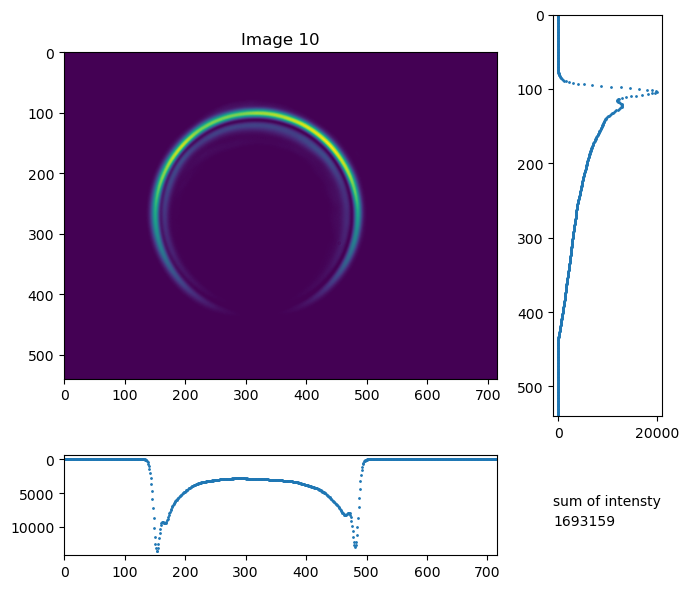

In [150]:
i=10
image_full_path=f"/home/melanie/Desktop/Conical_Refraction_Polarimeter/DATA/EXPERIMENTAL/Fotos_Turpin/Day3/Reference/Reference__{i}.png"
im = cv2.imread(image_full_path, cv2.IMREAD_ANYDEPTH)
prof_x=np.sum(im, axis=0)
prof_y=np.sum(im, axis=1)

fig,ax = plt.subplots(2,2,figsize = (7,6),gridspec_kw={'height_ratios': [4, 1],'width_ratios': [4, 1]})
ax[0,0].imshow(im)
ax[0,0].set_title(f"Image {i}")
ax[0,1].scatter(prof_y, np.arange(len(prof_y)), s=1, label=f'Intensity profile in y')
ax[0,1].set_ylim((0,len(prof_y)))
ax[0,1].invert_yaxis()
ax[1,0].scatter(np.arange(len(prof_x)), prof_x, s=1, label=f'Intensity profile in y')
ax[1,0].set_xlim((0,len(prof_x)))
ax[1,0].invert_yaxis()
ax[1,1].axis('off')
ax[1,1].text(0,0.5,"sum of intensty")
ax[1,1].text(0,0.3,f"{np.sum(im)}")
fig.tight_layout()
plt.show()
fig = go.Figure(data=[go.Surface(z=im[::4,::4], colorscale='Portland')])
fig.update_layout(title=f"Image {i}", autosize=False,
    width=500, height=450,
    margin=dict(l=1, r=1, b=1, t=30),
    scene={"aspectratio": {"x": max(w,h)/w, "y": max(w,h)/h, "z": 1}})
#clear_output(wait=True) # erase notebook cell's previous output
fig.show()
#time.sleep(10)

